# Proyecto: Predicción de Alzheimer a partir de MRI usando Deep Learning




## **0. Integrantes del equipo de trabajo**
---
1. RAÚL RAMÍREZ PENAGOS
2. IVÁN QUEVEDO
3. LINA ÁVILA MORENO

## **1. Entendimiento de los datos**

El conjunto de datos contiene 4 clases y etiquetas del 0 al 3:

1. Non demented : '0'
2. Very midly demented : '1'
3. Mildly demented : '2'
4. Moderately demented : '3'

In [ ]:
#pip install opencv-python
#!pip install tensorflow

In [ ]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import hashlib
import matplotlib.cm as cm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import random
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau



In [ ]:
#!pip install pyarrow

In [ ]:
# Ejecución local
local_path = "~/Downloads/diplomado/mlds3"
df_train = pd.read_parquet(f"{local_path}/train.parquet")
df_test = pd.read_parquet(f"{local_path}/test.parquet")

In [ ]:
df_train.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


In [ ]:
df_test.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1280 non-null   object
 1   label   1280 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.1+ KB


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5120 entries, 0 to 5119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5120 non-null   object
 1   label   5120 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.1+ KB


In [ ]:
etiqueta_enfermedad_categoria = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}

In [ ]:
def decodificar_imagen(image_dict):
    if isinstance(image_dict, dict) and "bytes" in image_dict:
        byte_string = image_dict["bytes"]
        datos_raw_np = np.frombuffer(byte_string, np.uint8)

        # Cargar en escala de grises (1 canal)
        img = cv2.imdecode(datos_raw_np, cv2.IMREAD_GRAYSCALE)

        # Redimensionar
        img = cv2.resize(img, (224, 224))

        # Expandir a 3 canales se replicó la imagen en gris
        img_3ch = np.stack([img, img, img], axis=-1)

        return img_3ch

    else:
        raise TypeError(f"Se esperaba un diccionario {type(image_dict)}")

## **2. Modelo**

In [ ]:
def oversample(X, y):
    X_bal = list(X)
    y_bal = list(y)

    values, counts = np.unique(y, return_counts=True)
    max_count = counts.max()

    for cls, count in zip(values, counts):
        if count < max_count:
            deficit = max_count - count
            indices = np.where(y == cls)[0]
            sampled_idx = np.random.choice(indices, deficit, replace=True)

            X_bal.extend(X[sampled_idx])
            y_bal.extend(y[sampled_idx])

    return np.array(X_bal), np.array(y_bal)

X = np.stack(df_train['img_arr'].values)
y = df_train['label'].values

X_bal, y_bal = oversample(X, y)

print("Dataset balanceado:", np.bincount(y_bal))


Dataset balanceado: [2566 2566 2566 2566]


In [ ]:
#Partición del conjunto de datos

X_train, X_temp, y_train, y_temp = train_test_split(
    X_bal, y_bal, test_size=0.25, stratify=y_bal, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(np.bincount(y_train), np.bincount(y_val), np.bincount(y_test))

[1924 1925 1924 1925] [321 320 321 321] [321 321 321 320]


In [ ]:
train_datagen = ImageDataGenerator(
    zoom_range=0.02,
    rotation_range=2,
    brightness_range=[0.9, 1.1],
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

batch_size = 32

train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
val_gen   = val_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)


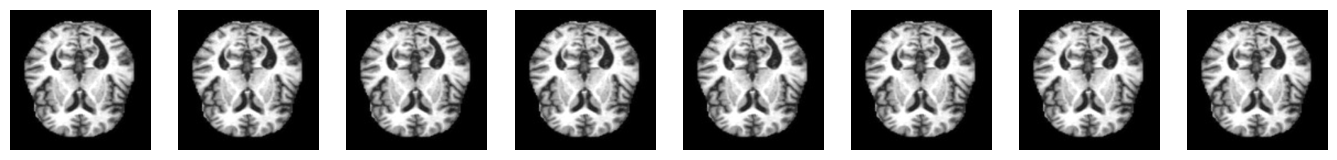

In [ ]:
def normalize_mri_for_display(img):
    p2, p98 = np.percentile(img, (2, 98))
    img = np.clip(img, p2, p98)
    img = (img - img.min()) / (img.max() - img.min() + 1e-10)
    return img
random_index = random.randint(0, len(df_train) - 1)

image_data = df_train.loc[random_index, 'img_arr']  # (H,W,1)

x = image_data.reshape((1,) + image_data.shape)

fig, axs = plt.subplots(1, 8, figsize=(17, 4))

i = 0
for batch in ImageDataGenerator().flow(x, batch_size=1):
    img = batch[0][:,:,0]

    # ⚡ Normalizamos SOLO para visualización
    img_norm = normalize_mri_for_display(img)

    axs[i].imshow(img_norm, cmap='gray')
    axs[i].axis('off')

    i += 1
    if i == 8:
        break

plt.show()



In [ ]:
#verificando dimensiones
print(df_train['img_arr'].iloc[0].shape)


(224, 224, 3)


In [ ]:
unique, counts = np.unique(y_bal, return_counts=True)
print(dict(zip(unique, counts)))

{0: 2566, 1: 2566, 2: 2566, 3: 2566}


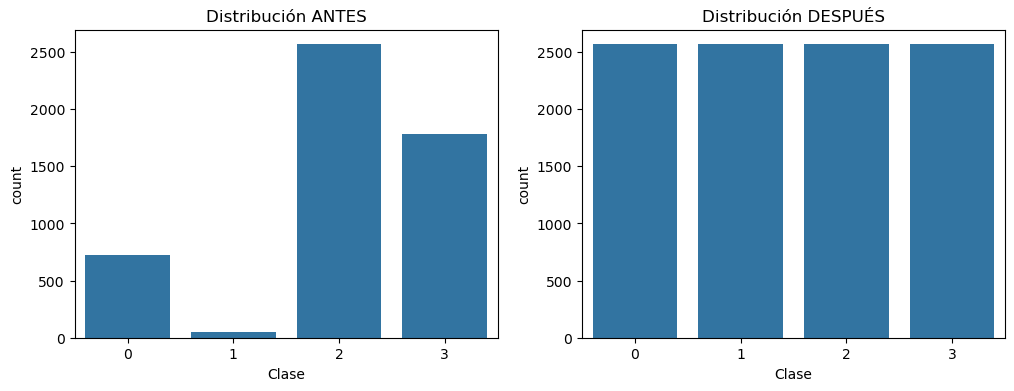

In [ ]:
# Dataframes para graficar
df_before = pd.DataFrame({"Clase": y})
df_after  = pd.DataFrame({"Clase": y_bal})

fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.countplot(data=df_before, x="Clase", ax=ax[0])
ax[0].set_title("Distribución ANTES")

sns.countplot(data=df_after, x="Clase", ax=ax[1])
ax[1].set_title("Distribución DESPUÉS")

plt.show()